# For Synthetic Dataset

Try Gamma Poisson Model inference on data generated from that model. Creates and recovers synthetic data.

### If you want overdispersion in the model:
Set the following to `True`:

In [1]:
overdisp = True
hierarchical_overdisp = False

# Generate Test Data

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import spiketopics.gamma_model as gp
from spiketopics.helpers import *
import cPickle as pickle
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_style('darkgrid')

np.random.seed(11739)
savefigs = False

/Users/jmxp/anaconda/envs/python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Define model parameters

In [3]:
U = 20  # units
dt_data = 1/100  # time bin for data generation
dt = 1/100  # time bin for inference
trial_dur = 1  # trial duration (seconds)
Tdata = int(trial_dur / dt_data)  # time points/frames
T = int(trial_dur / dt)
Kdata = 3  # number of latent states
Mtu = 200  # number of trials

In [4]:
dt, T

(0.01, 100)

## Generate Markov chains

In [5]:
# make transition matrix
A = np.array([[0.95, 0.05], [0.05, 0.95]])

In [6]:
chain = np.empty((Tdata, Kdata))

chain[0, :] = 0  # start all categories "off"
for t in xrange(1, Tdata):
    for k in xrange(Kdata):
        chain[t, k] = stats.bernoulli.rvs(A[1, int(chain[t - 1, k])])

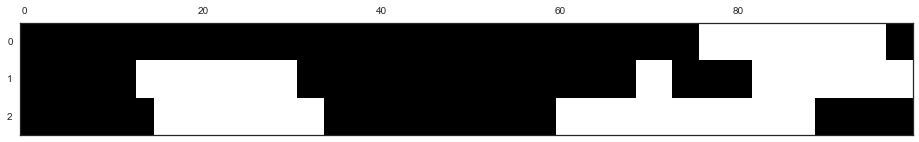

In [7]:
matshow(chain.T);

## Baseline distributions

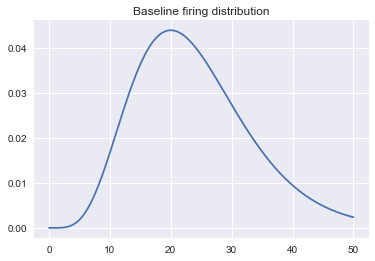

In [8]:
bl_shape = 6
bl_scale = 4
# baselines should follow a different distribution
bl = stats.gamma.rvs(a=bl_shape, scale=bl_scale, size=U) 

xx = np.linspace(0, 50, 1000)
plt.plot(xx, stats.gamma.pdf(xx, a=bl_shape, scale=bl_scale))
plt.title('Baseline firing distribution');

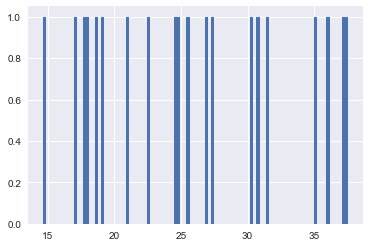

In [9]:
plt.hist(bl.ravel(), bins=100);

## Firing rate effect distributions

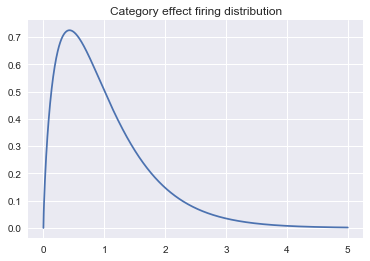

In [10]:
# firing rates
fr_shape = 1.75
fr_rate = 1.75
lam = stats.gamma.rvs(a=fr_shape, scale=1/fr_rate, size=(Kdata, U))

xx = np.linspace(0, 5, 1000)
plt.plot(xx, stats.gamma.pdf(xx, a=fr_shape, scale=1/fr_rate))

plt.title('Category effect firing distribution');

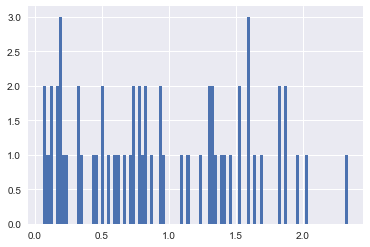

In [11]:
plt.hist(lam.ravel(), bins=100);

## Overdispersion

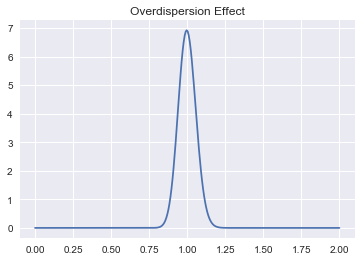

In [12]:
if overdisp:
    xx = np.linspace(0, 2, 300)
    th_shape = 300
    plt.plot(xx, stats.gamma.pdf(xx, a=th_shape, scale=1./th_shape))
    plt.title('Overdispersion Effect');

## External regressors

In [13]:
# just as above, make a set of Markov-esque regressors

# number of regressors
R = 3  

# "transition matrix" -- want regressors to have some temporal coherence
AX = np.array([[0.95, 0.07], [0.05, 0.93]])

In [14]:
Xchain = np.empty((Tdata, R))

Xchain[0, :] = (np.random.rand(R) > 0.5)  # start regressors category off
for t in xrange(1, Tdata):
    for k in xrange(0, R):
        Xchain[t, k] = stats.bernoulli.rvs(AX[1, int(Xchain[t - 1, k])])

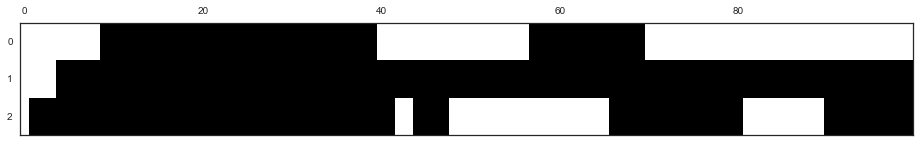

In [15]:
matshow(Xchain.T);

In [16]:
Xf = pd.DataFrame(Xchain, columns=map(lambda x: 'X' + str(x), xrange(R)))
Xf.index.name = 'frame'
Xf = Xf.reset_index()

In [17]:
Xf.head()

,frame,X0,X1,X2
0,0,1.0,1.0,1.0
1,1,1.0,1.0,0.0
2,2,1.0,1.0,0.0
3,3,1.0,1.0,0.0
4,4,1.0,0.0,0.0


In [18]:
# make firing rate effects for each (regressor, unit)
Xfr_shape = 45
Xfr_scale = 1. / 45
Xlam = stats.gamma.rvs(a=Xfr_shape, scale=Xfr_scale, size=(R, U))

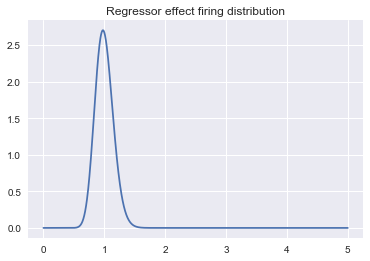

In [19]:
xx = np.linspace(0, 5, 1000)
plt.plot(xx, stats.gamma.pdf(xx, a=Xfr_shape, scale=Xfr_scale))
plt.title('Regressor effect firing distribution');

## Calculate firing rates

Let $\lambda_0$ be the baseline, $\lambda_k$ the firing rate for latent category $i$ with binary indicator variable $z_{tk}$ and $\nu_{r}$ be the firing rate effect for external regressor $r$ with value $x_{tr}$. Let $\theta_{t}$ be an overdispersion factor for each time bin. The firing rate of unit $u$ at time $t$ is then given by

$$
\Lambda_{tu} = \lambda_{0u} \theta_{tu} \prod_k  \lambda_{ku}^{z_{tk}}
\prod_r \nu_{ru}^{x_{tr}}
$$

In [20]:
# calculate rate within each time bin
fr = bl * np.exp(chain.dot(np.log(lam)) + Xchain.dot(np.log(Xlam))) * dt_data
fr += 1e-5  # in case we get exactly 0
# fr = np.tile(fr, (1, Mtu)).ravel()
fr = np.tile(fr, (Mtu, 1))

# add overdispersion
if overdisp:
    theta = stats.gamma.rvs(a=th_shape, scale=1/th_shape, size=fr.shape)
    fr *= theta

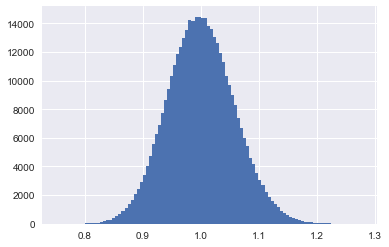

In [21]:
plt.hist(theta.ravel(), bins=100);

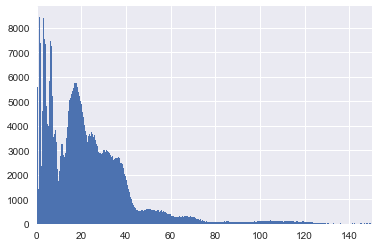

In [22]:
# get a crude sense of population firing
plt.hist(fr.ravel() / dt_data, bins=1000);
plt.xlim(0, 150);

## Look at generated data

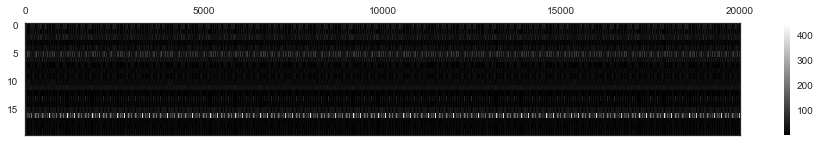

In [23]:
matshow(fr.T / dt_data);
plt.colorbar();

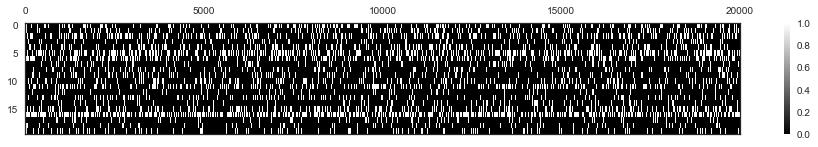

In [24]:
# draw from Poisson
N = stats.poisson.rvs(fr)
matshow(N.T, vmax=1);
plt.colorbar();

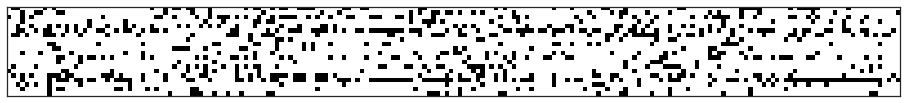

In [25]:
# make camera-ready raster for figure
with sns.axes_style('white'):
    plt.matshow(1 - N.T[:50, :200], vmin=0, vmax=1, interpolation='none',
               cmap='gray')
    plt.xticks([])
    plt.yticks([])

if savefigs:
    plt.savefig('raster.svg')

## Make count dataframe

In [26]:
# make counts into a data frame
df = pd.DataFrame(N)
df.index.name = 'bin'

# re-bin data based on analysis dt
bin_ratio = int(dt / dt_data)
df = df.groupby(df.index // bin_ratio).sum()

# make a frame column (same frames repeat every trial)
df.index.name = 'frame'
df = df.reset_index()
df.frame = np.tile(range(T), Mtu) # frames repeat Mtu times

# melt and add movie column
df = pd.melt(df, id_vars='frame')
df.columns = ['frame', 'unit', 'count']
df.unit = df.unit.astype('int64')
df['movie'] = 1

# downsample X regressors and merge
Xds = Xf.groupby(Xf.index // bin_ratio).mean()
Xds = Xds.drop('frame', axis=1)
Xds.index.name = 'frame'
Xds = Xds.reset_index()

df = df.merge(Xds)

df.head()

,frame,unit,count,movie,X0,X1,X2
0,0,0,0,1,1.0,1.0,1.0
1,0,0,0,1,1.0,1.0,1.0
2,0,0,0,1,1.0,1.0,1.0
3,0,0,1,1,1.0,1.0,1.0
4,0,0,1,1,1.0,1.0,1.0


Finally, convert (frame, movie) pairs to unique times:

In [27]:
df = frames_to_times(df)
M = df.shape[0]
df.head()

,unit,count,X0,X1,X2,time
0,0,0,1.0,1.0,1.0,0
1,0,0,1.0,1.0,1.0,0
2,0,0,1.0,1.0,1.0,0
3,0,1,1.0,1.0,1.0,0
4,0,1,1.0,1.0,1.0,0


# Set up Priors

## Priors on baseline:

We will use a hierarchical model for both baselines and firing rate effects, with  
$$
\lambda_{u} \sim \mathrm{Ga}(c, cd) \\
c \sim \text{Ga}(a_c, b_c) \\
d \sim \text{Ga}(a_d, b_d) \\
\mathbb{E}[\lambda_{u}] = \frac{1}{d} \\
\mathrm{var}[\lambda_{u}] = \frac{1}{c d^2}
$$
In other words, we can think of $\frac{1}{d}$ as a *mean parameter* and $\frac{1}{c}$ as a *variance parameter*.

We want the baseline rates to have a fairly reasonable prior and the effect rates to have a very sparse prior, closely concentrated around 1.

The following function will help us get a sense of the distribution on $\lambda$ induced by our hyperparameter choices.

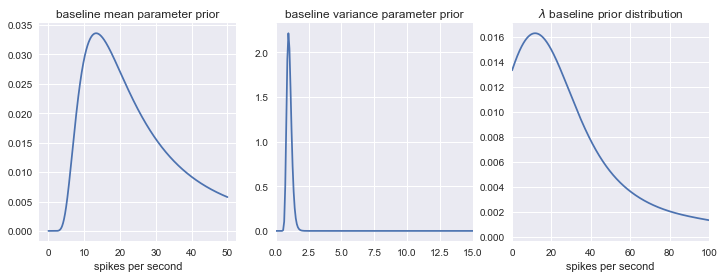

In [28]:
bl_mean_shape = 2.
bl_mean_rate = 40 * dt  # actual parameter should be per-bin rate
bl_shape_shape = 30.
bl_shape_rate = 30.

baseline_dict = ({
            'prior_shape_shape': bl_shape_shape, 
            'prior_shape_rate': bl_shape_rate, 
            'prior_mean_shape': bl_mean_shape, 
            'prior_mean_rate': bl_mean_rate})

# make some plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
xx = np.linspace(0, 50, 1000)
plt.plot(xx, stats.invgamma.pdf(xx, a=bl_mean_shape, scale=bl_mean_rate / dt))
plt.title('baseline mean parameter prior');
plt.xlabel('spikes per second')

plt.subplot(1, 3, 2)
xx = np.linspace(0, 80, 1000)
plt.plot(xx, stats.invgamma.pdf(xx, a=bl_shape_shape, scale=bl_shape_rate))
plt.title('baseline variance parameter prior');
plt.xlim(0, 15)

plt.subplot(1, 3, 3)
samples = gamma_from_hypers([bl_mean_shape, bl_mean_rate], 
                            [bl_shape_shape, bl_shape_rate], 10**4)
sns.kdeplot(samples / dt, gridsize=1e4, clip=(0, 150))
plt.title(r'$\lambda$ baseline prior distribution')
plt.xlim(0, 100);
plt.xlabel('spikes per second');



## Priors on latent firing rate effects:

In [29]:
# set number of categories to fit
K = 5

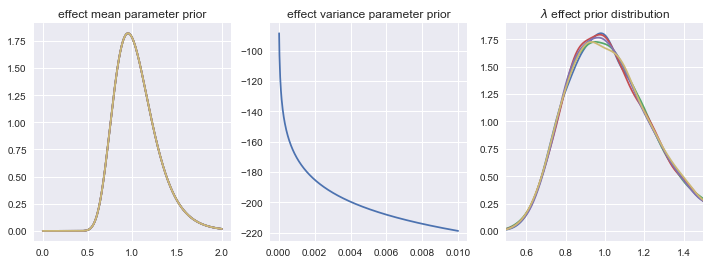

In [30]:
fr_shape_shape = 20 * np.ones((K,))
fr_shape_rate = 1e-6 * np.ones((K,))
# fr_mean_shape = U * np.geomspace(1, 1000, K)
# fr_mean_rate = U * np.geomspace(1, 1000, K)
fr_mean_shape = U * np.ones(K)
fr_mean_rate = U * np.ones(K)

fr_latent_dict = ({
            'prior_shape_shape': fr_shape_shape, 
            'prior_shape_rate': fr_shape_rate, 
            'prior_mean_shape': fr_mean_shape, 
            'prior_mean_rate': fr_mean_rate})

# make some plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
xx = np.linspace(0, 2, 500)
for k in range(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=fr_mean_shape[k], scale=fr_mean_rate[k]))
plt.title('effect mean parameter prior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 0.01, 500)
plt.plot(xx, stats.invgamma.logpdf(xx, a=fr_shape_shape[0], scale=fr_shape_rate[0]))
plt.title('effect variance parameter prior');

plt.subplot(1, 3, 3)
for k in range(K):
    samples = gamma_from_hypers([fr_mean_shape[k], fr_mean_rate[k]], 
                                [fr_shape_shape[k], fr_shape_rate[k]], 10**4)
    sns.kdeplot(samples, gridsize=5000, clip=(0, 5))
plt.title(r'$\lambda$ effect prior distribution')
plt.xlim(0.5, 1.5);

## Priors on $A$, $\pi$

In [31]:
###### A ###############
A_off = 10.
A_on = 1.
Avec = np.r_[A_off, A_on].reshape(2, 1, 1)
A_prior = np.tile(Avec, (1, 2, K))

###### pi ###############
pi_off = 15.
pi_on = 1.
pi_prior = np.tile(np.r_[pi_off, pi_on].reshape(2, 1), (1, K))

latent_dict = {'A_prior': A_prior, 'pi_prior': pi_prior}

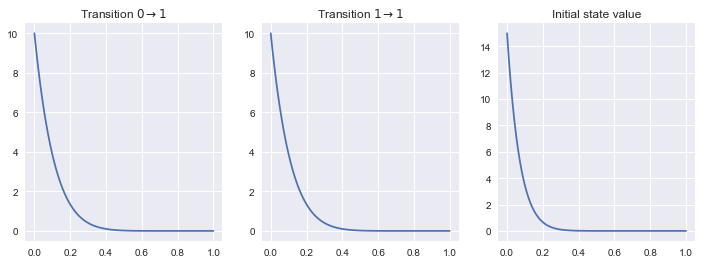

In [32]:
xx = np.linspace(0, 1, 100)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(xx, stats.beta.pdf(xx, A_prior[1, 0, 0], A_prior[0, 0, 0]))
plt.title(r'Transition $0 \rightarrow 1$');

plt.subplot(1, 3, 2)
plt.plot(xx, stats.beta.pdf(xx, A_prior[1, 1, 0], A_prior[0, 1, 0]))
plt.title(r'Transition $1 \rightarrow 1$');

plt.subplot(1, 3, 3)
plt.plot(xx, stats.beta.pdf(xx, pi_prior[1, 0], pi_prior[0, 0]))
plt.title('Initial state value');


## Priors on $\theta$ (overdispersion)

In [33]:
if not hierarchical_overdisp:
    od_shape = 60.
    od_rate = 60.
    od_dict = {'prior_shape': od_shape * np.ones((M,)), 'prior_rate': od_rate * np.ones((M,))}

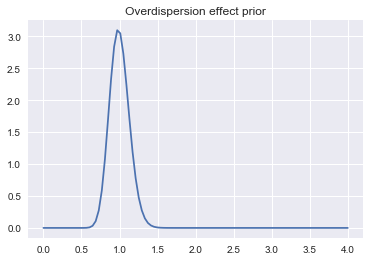

In [34]:
if not hierarchical_overdisp:
    xx = np.linspace(0, 4, 100)
    plt.plot(xx, stats.gamma.pdf(xx, a=od_shape, scale=1./od_rate))
    plt.title('Overdispersion effect prior');

In [35]:
if hierarchical_overdisp:
    od_parent_shape = 0.2 * T
    od_parent_rate = 0.25
    od_dict = ({
            'prior_parent_shape': od_parent_shape * np.ones((U,)),
            'prior_parent_rate': od_parent_rate * np.ones((U,)),
            'mapper': df['unit'].astype('int')
        })

    # make some plots
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    # nail the mean to be 1
    TH = 1e6
    xx = np.linspace(0, 2, 500)
    plt.plot(xx, stats.invgamma.pdf(xx, a=TH, scale=TH))
    plt.title('overdispersion mean parameter prior');

    plt.subplot(1, 3, 2)
    xx = np.linspace(0, 0.1, 500)
    plt.plot(xx, stats.invgamma.pdf(xx, a=od_parent_shape, scale=od_parent_rate))
    plt.title('effect variance parameter prior');

    plt.subplot(1, 3, 3)
    samples = gamma_from_hypers([TH, TH], 
                                [od_parent_shape, od_parent_rate], 10**4)
    sns.kdeplot(samples, gridsize=5000, clip=(0, 5))
    plt.title(r'$\theta$ prior distribution')
    plt.xlim(0, 3);

## Priors on $\upsilon$ (regression coefficients)

In [36]:
ups_shape = 10.
ups_rate = 10.
reg_shape = ups_shape * np.ones((U, R))  # shape
reg_rate = ups_rate * np.ones((U, R))  # rate

reg_dict = {'prior_shape': reg_shape, 'prior_rate': reg_rate}

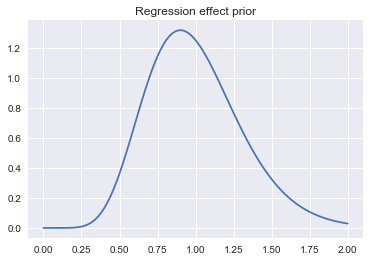

In [37]:
xx = np.linspace(0, 2, 100)
plt.plot(xx, stats.gamma.pdf(xx, a=ups_shape, scale=1./ups_rate))
plt.title('Regression effect prior');

# Initial guesses for posterior parameters

In [38]:
# baseline posteriors
bld = ({'post_shape_shape': bl_shape_shape, 'post_shape_rate': bl_shape_rate, 
        'post_mean_shape': bl_mean_shape, 'post_mean_rate': bl_mean_rate,
        'post_child_shape': np.ones((U,)), 'post_child_rate': np.ones((U,))})
baseline_dict.update(bld)

In [39]:
# firing rate effects for latents
frd = ({'post_shape_shape': fr_shape_shape, 'post_shape_rate': fr_shape_rate, 
        'post_mean_shape': fr_mean_shape, 'post_mean_rate': fr_mean_rate,
        'post_child_shape': np.ones((U, K)), 'post_child_rate': np.ones((U, K))})
fr_latent_dict.update(frd)

In [40]:
# latent states

# E[z]
# initialize pretty much at random (10% 1's)
rand_frac = 0.1

def draw_xi():
#     xi_mat = (rand_frac >= np.random.rand(T, K))
    xi_mat = np.random.rand(T, K)
    xi_mat = xi_mat.astype('float')
    z_prior = np.dstack([1 - xi_mat, xi_mat]).transpose((2, 0, 1))
    return z_prior

# E[zz]
def draw_Xi():
#     Xi_mat = rand_frac >= np.random.rand(2, 2, T - 1, K)
    Xi_mat = np.random.rand(2, 2, T - 1, K)
    Xi_mat = Xi_mat.astype('float')
    return Xi_mat

ld = ({'A_post': A_prior, 'pi_post': pi_prior, 'z_init': draw_xi(),
       'zz_init': draw_Xi(), 'logZ_init': np.zeros((K,))})
latent_dict.update(ld)

In [41]:
# firing rate regressors
# since we know exact update for a_mat, use that
nn = df['count']
uu = df['unit']
NX = nn[:, np.newaxis] * df.iloc[:, -R:]
a_mat = NX.groupby(uu).sum().values + reg_shape
b_mat = a_mat.copy() + reg_rate

reg_dict.update({'post_shape': a_mat, 'post_rate': b_mat})

In [42]:
# overdispersion

if hierarchical_overdisp:
    od_dict.update({
            'post_parent_shape': np.ones((U,)),
            'post_parent_rate': np.ones((U,)),
            'post_child_shape': np.ones((M,)),
            'post_child_rate': np.ones((M,))
        })
else:
    od_dict.update({'post_shape': np.ones((M,)), 'post_rate': np.ones((M,))})

# Do inference with random restarts:

In [43]:
numstarts = 10
od_natural = False

In [44]:
fitobjs = []
Lvals = []
for idx in xrange(numstarts):
    gpm = gp.GammaModel(df, K)
    gpm.initialize_baseline(**jitter_inits(baseline_dict, 0.25))
    gpm.initialize_fr_latents(**jitter_inits(fr_latent_dict, 0.25))
    ld = {'z_init': draw_xi(),
       'zz_init': draw_Xi()}
    latent_dict.update(ld)
    gpm.initialize_latents(**jitter_inits(latent_dict, 0.25))
    gpm.initialize_fr_regressors(**jitter_inits(reg_dict, 0.25))
    if overdisp:
        gpm.initialize_overdispersion(**jitter_inits(od_dict, 0.25))
    gpm.finalize()
    
    print "Start {} -----------------------".format(idx)
    %time gpm.do_inference(tol=1e-4, verbosity=0)
    print "Final L = {}".format(gpm.L())
    Lvals.append(gpm.L())
    fitobjs.append(gpm)

Start 0 -----------------------
CPU times: user 1min 4s, sys: 4.18 s, total: 1min 8s
Wall time: 36.7 s
Final L = -198438.352831
Start 1 -----------------------
CPU times: user 1min 23s, sys: 6.3 s, total: 1min 29s
Wall time: 45.9 s
Final L = -197525.893609
Start 2 -----------------------
CPU times: user 1min 2s, sys: 4.07 s, total: 1min 6s
Wall time: 33.1 s
Final L = -198540.493149
Start 3 -----------------------
CPU times: user 54.3 s, sys: 3.26 s, total: 57.5 s
Wall time: 28.5 s
Final L = -198067.019462
Start 4 -----------------------
CPU times: user 47.9 s, sys: 2.96 s, total: 50.8 s
Wall time: 25.9 s
Final L = -198197.791578
Start 5 -----------------------
CPU times: user 56.6 s, sys: 3.73 s, total: 1min
Wall time: 30.6 s
Final L = -198340.618629
Start 6 -----------------------
CPU times: user 43.1 s, sys: 2.67 s, total: 45.7 s
Wall time: 23.8 s
Final L = -199300.949775
Start 7 -----------------------
CPU times: user 1min 4s, sys: 4.3 s, total: 1min 9s
Wall time: 34.6 s
Final L = -

In [45]:
# pick out best fit
bestind = np.argmax(Lvals)
gpm = fitobjs[bestind]
del fitobjs  # to save memory

In [46]:
# Cleaning up...
# need to get rid of externally defined functions for pickling
# also has the effect of "neutering" object from futher update
for name, node in gpm.nodes.iteritems():
    attrs = node.__dict__.keys()
    to_delete = [a for a in attrs if 'update' in a or 'log_prior' in a]
    for a in to_delete:
        delattr(node, a)
        
# Writing to disk...
outfile = 'fitted_model_object.pkl'
pickle.dump(gpm, open(outfile, 'wb'))

# Check results

## Do we correctly recover $z$?

Zoom in on a small part of the time series:

In [47]:
Xs = []
for i in range(3):
    Xs.append("X{}".format(i))
    
features = []
for i in range(5):
    features.append("Feature {}".format(i))


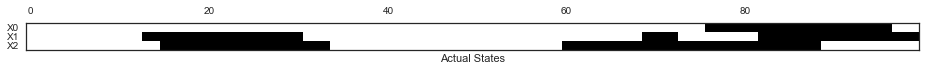

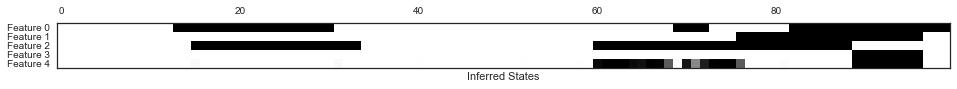

In [48]:
if savefigs:
    sns.set_context('talk')

#Trng = (500, 1000)
with sns.axes_style("white"):
    plt.figure(figsize=(20, 2))
    ax = plt.matshow(chain.T, vmin=0, vmax=1);
# matshow(chain.T[:, slice(*Trng)], vmin=0, vmax=1);
plt.yticks(xrange(len(Xs)), Xs[:3])
plt.xlabel('Actual States')

if savefigs:
    plt.savefig('synthetic_actual.svg', format="svg", bbox_inches='tight')

xi = gpm.nodes['HMM'].nodes['z'].z[1]
xi = np.repeat(xi, bin_ratio, axis=0) # upsample xi

xishow = xi.T #[:, slice(*Trng)]
#xishow = np.c_[xishow[4, :], xishow[1, :], xishow[2, :], xishow[0, :], xishow[3, :]].T

# matshow(xi.T[:, slice(*Trng)], vmin=0, vmax=1);
with sns.axes_style("white"):
    # plt.figure(figsize=(20, 2))
    ax = plt.matshow(xishow, vmin=0, vmax=1);
plt.yticks(xrange(len(features)), features)
plt.xlabel('Inferred States')

if savefigs:
    plt.savefig('synthetic_inferred.svg', format="svg", bbox_inches='tight')

# sns.set()

What about the whole time series?

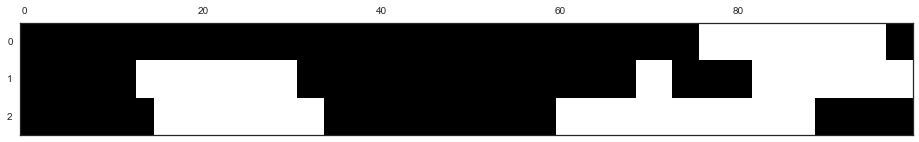

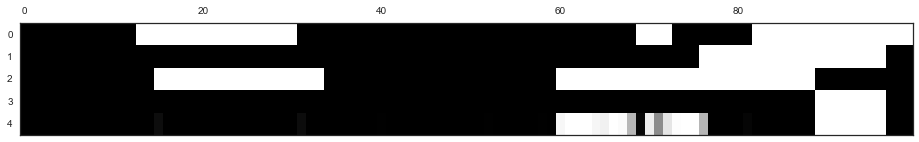

In [49]:
matshow(chain.T, vmin=0, vmax=1);
matshow(xi.T, vmin=0, vmax=1);

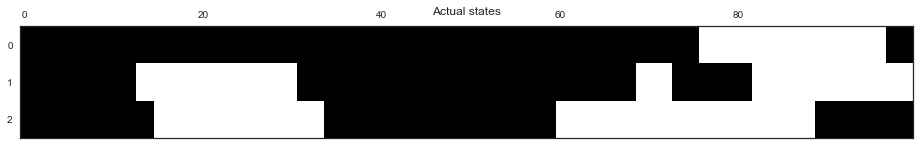

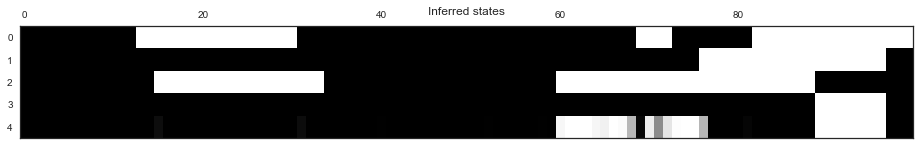

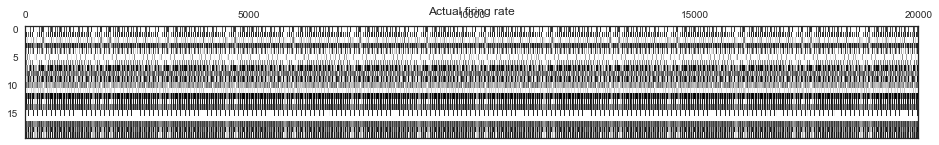

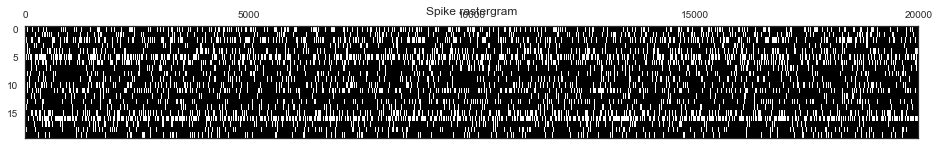

In [50]:
matshow(chain[:, :200].T);
plt.title('Actual states')
matshow(xi[:, :200].T, vmin=0, vmax=1);
plt.title('Inferred states')
matshow(fr.T / dt, vmax=30);
plt.title('Actual firing rate')
matshow(N.T, vmin=0, vmax=1);
plt.title('Spike rastergram');

In [51]:
# make a normalizer so we can set the colormap midpoint
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_invalid(np.interp(value, x, y))

norm = MidpointNormalize(midpoint=1., vmin=0.7, vmax=1.3)
cmap = plt.cm.RdBu_r
cmap.set_bad(color='k', alpha=1.0)

Mean absolute unit effects [ 43.48439063  65.67358335  52.77845053  25.45744404  11.55776083]


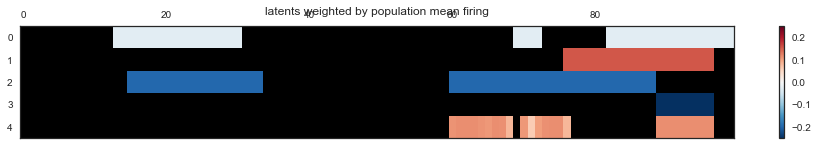

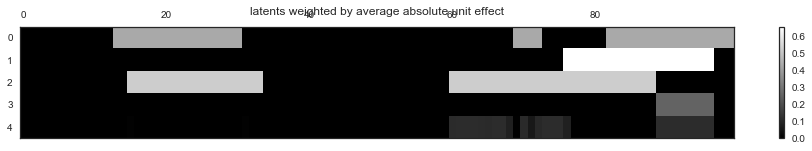

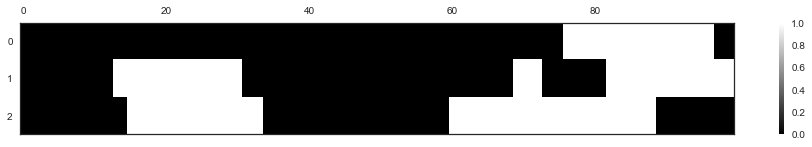

In [53]:
# scale z by population lambda
th = gpm.nodes['fr_latents_mean']
th_pars = np.c_[th.post_shape, th.post_rate].T
effsize = (th_pars[1] / (th_pars[0] - 1)) - 1  # mean of posterior for mean effect size
effmat = (effsize * xi).T
effmat_cens = effmat.copy()
effmat_cens[np.abs(effmat_cens) < 0.01] = np.nan

# mean of abs unit lambda means
lam_inf = gpm.nodes['fr_latents'].expected_x()
lam_inf_bar = np.abs(lam_inf - 1).mean(axis=0)

with sns.axes_style("white"):
    norm = MidpointNormalize(midpoint=0., vmin=-.25, vmax=.25)
    ax = plt.matshow(effmat_cens, aspect='auto', cmap=cmap, norm=norm);
    cbar = plt.colorbar();
    plt.title("latents weighted by population mean firing")

    norm = MidpointNormalize(midpoint=0., vmin=-.25, vmax=.25)
    ax = plt.matshow((lam_inf_bar * xi).T, aspect='auto', cmap='gray');
    cbar = plt.colorbar();
    plt.title("latents weighted by average absolute unit effect")


# cbar.set_ticks([-.25, -.125, 0, .125, .25])
# cbar.set_ticklabels(['-28%', '-13%', '0%', '13%', '28%'])
# matshow(effmat);
matshow(chain.T, vmin=0, vmax=1); plt.colorbar();

print "Mean absolute unit effects {}".format(lam_inf_bar * 100)

## Calculate overlap between actual and inferred latents

In [54]:
match = (chain.T.dot(xi) + (1 - chain.T).dot(1 - xi)) / T
mismatch = (chain.T.dot(1 - xi) + (1 - chain.T).dot(xi)) / T
overlap = np.maximum(match, mismatch)

Define the overlap as the maximum of the match or mismatch percentage. That is, if $x$ and $y$ are binary vectors, 
$$
\mathrm{overlap} = \max \{ \mathbb{E}[xy + (1-x)(1-y)], \mathbb{E}[(1-x)y + x(1-y)]\}
$$

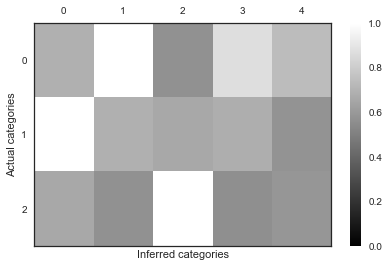

In [55]:
matshow(overlap, vmin=0, vmax=1)
plt.colorbar();
plt.xlabel('Inferred categories');
plt.ylabel('Actual categories');

## Mutual Information

In [56]:
mi_mat = mutual_information_matrix(chain, xi)

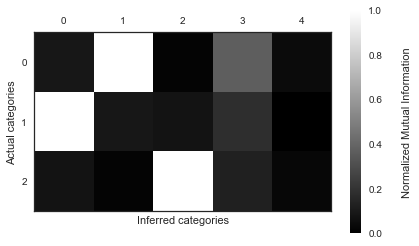

In [57]:
if savefigs:
    sns.set_context('talk', font_scale=1.5)

with sns.axes_style("white"):
    ax = plt.matshow(mi_mat, cmap='gray', vmin=0, vmax=1);
cb = plt.colorbar();

cb.set_label('Normalized Mutual Information', labelpad=20)
plt.xlabel('Inferred categories');
plt.ylabel('Actual categories');

if savefigs:
    plt.savefig('synthetic_mi_matrix.svg', format="svg", bbox_inches='tight')
    sns.set()

## Check firing rates

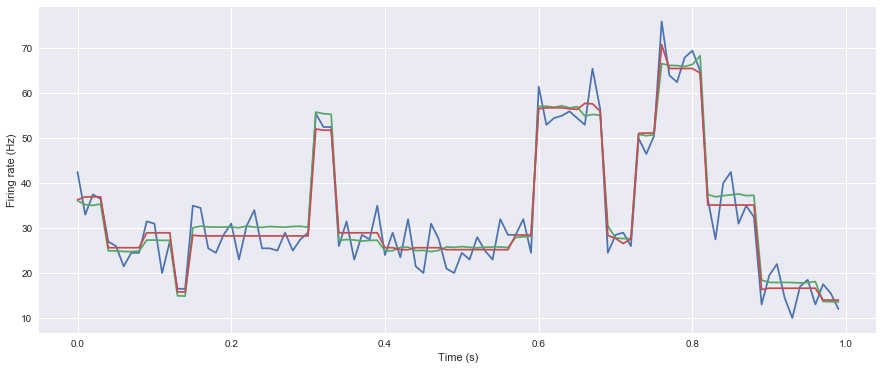

In [58]:
unit = 2
bl = gpm.nodes['baseline'].expected_x() / dt
lam_inf = gpm.nodes['fr_latents'].expected_x()
reg_inf = gpm.nodes['fr_regressors'].expected_x()

pred = np.exp(np.log(bl)[:, np.newaxis] + np.log(lam_inf).dot(xi.T) + np.log(reg_inf).dot(Xds.values[:, 1:].T))

plt.figure(figsize=(15, 6))
tt = np.arange(0, Tdata*dt, dt)

# plot mean of underlying firing 
psth = N[:, unit].reshape(Mtu, Tdata).mean(axis=0) / dt_data
plt.plot(tt, psth)
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Time (s)')

# plot mean spikes across trials
fr_mean = fr[:, unit].reshape(Mtu, Tdata).mean(axis=0) / dt_data
plt.plot(tt, fr_mean)
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Time (s)')

# plot model prediction
plt.plot(tt, pred[unit, :])

## Diagnostics for gamma-distributed variables

Let's look at what we get for $\lambda$, $\theta$, and $\upsilon$:

### Baselines

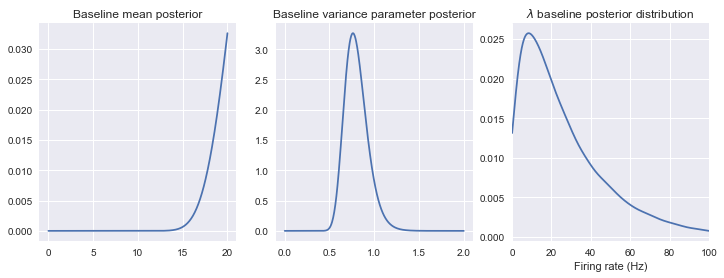

In [59]:
plt.figure(figsize=(12, 4))

th = gpm.nodes['baseline_mean']
cc = gpm.nodes['baseline_shape']
th_pars = [th.post_shape, th.post_rate]
cc_pars = [cc.post_shape, cc.post_rate]
samples = gamma_from_hypers(th_pars, cc_pars, 10**4)

plt.subplot(1, 3, 1)
xx = np.linspace(0, 20, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0], scale=th_pars[1]/dt))
plt.title('Baseline mean posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 2, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0], scale=cc_pars[1]))
plt.title('Baseline variance parameter posterior');

plt.subplot(1, 3, 3)
sns.kdeplot(samples / dt, gridsize=1e4, clip=(0, 100))
plt.title(r'$\lambda$ baseline posterior distribution')
plt.xlabel('Firing rate (Hz)')
plt.xlim(0, 100);

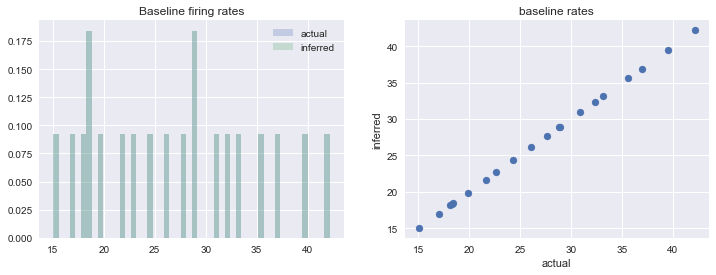

In [60]:
plt.figure(figsize=(12, 4))

inferred_means = gpm.nodes['baseline'].expected_x() / dt

plt.subplot(1, 2, 1)
plt.hist(bl, bins=50, normed=True, alpha=0.25)
plt.hist(inferred_means, bins=50, normed=True, alpha=0.25);
plt.legend(['actual', 'inferred']);
plt.title('Baseline firing rates');

plt.subplot(1, 2, 2)
plt.scatter(bl, inferred_means);
plt.xlabel('actual')
plt.ylabel('inferred')
plt.title('baseline rates');

### $\lambda$ terms (latents for each unit)

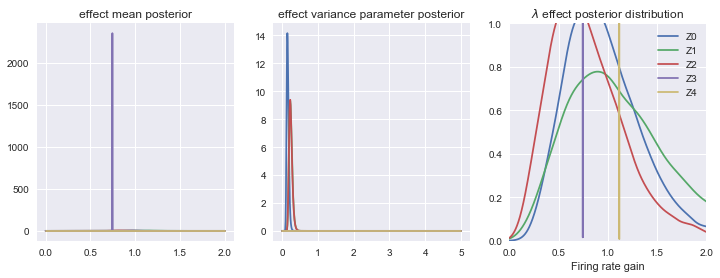

In [61]:
plt.figure(figsize=(12, 4))

th = gpm.nodes['fr_latents_mean']
cc = gpm.nodes['fr_latents_shape']
th_pars = np.c_[th.post_shape, th.post_rate].T
cc_pars = np.c_[cc.post_shape, cc.post_rate].T

plt.subplot(1, 3, 1)
xx = np.linspace(0, 2, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0, kk], scale=th_pars[1, kk]))
plt.title('effect mean posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 5, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0, kk], scale=cc_pars[1, kk]))
plt.title('effect variance parameter posterior');

plt.subplot(1, 3, 3)
mapping = range(5)
if savefigs:
    plt.figure()
    sns.set_context('talk', font_scale=1.5)
    sns.set_style('white')
    mapping = [2, 3, 1, 0, 4]

for kk in xrange(K):
    index = mapping[kk]
    samples = gamma_from_hypers(th_pars[:, index], cc_pars[:, index], 10**4)
    sns.kdeplot(samples, gridsize=1e4, clip=(0, 10), label='Z' + str(kk))
plt.legend()
plt.title(r'$\lambda$ effect posterior distribution')
plt.xlabel('Firing rate gain')
plt.xlim(0, 2);
plt.ylim(0, 1);

if savefigs:
    plt.savefig("synthetic_lambda.svg", format="svg")

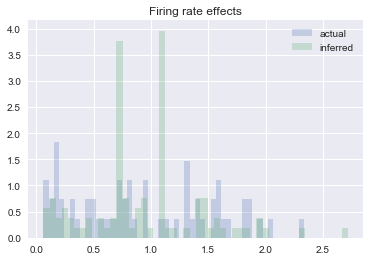

In [62]:
plt.hist(lam.ravel(), bins=50, normed=True, alpha=0.25)
inferred_effects = gpm.nodes['fr_latents'].expected_x().ravel()
plt.hist(inferred_effects, bins=50, normed=True, alpha=0.25);
plt.legend(['actual', 'inferred']);
plt.title('Firing rate effects');

### $\theta$ terms (overdispersion)

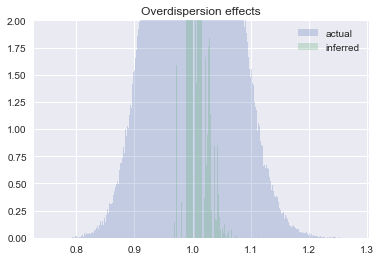

In [63]:
if overdisp:
    if hierarchical_overdisp:
        od_parent_means = gpm.nodes['overdispersion_parent'].expected_x()
        od_var = 1. / od_parent_means.ravel()
        plt.hist(od_var, bins=500, normed=True, alpha=0.25)
    else:
        inferred_means = gpm.nodes['overdispersion'].expected_x().ravel()
        plt.hist(theta.ravel(), bins=500, normed=True, alpha=0.25)
        plt.hist(inferred_means, bins=500, normed=True, alpha=0.25);
        plt.legend(['actual', 'inferred']);
        plt.title('Overdispersion effects');
        plt.ylim(0, 2);
        
#         plt.scatter(theta.ravel(), inferred_means, alpha=0.01);
#         plt.xlabel('actual')
#         plt.ylabel('inferred')
#         plt.title('overdispersion');

### $\upsilon$ terms (regressors)

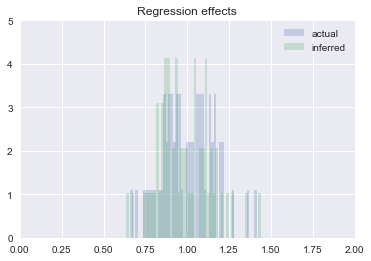

In [64]:
inferred_means = gpm.nodes['fr_regressors'].expected_x().ravel()
plt.hist(Xlam.ravel(), bins=50, normed=True, alpha=0.25)
plt.hist(inferred_means, bins=50, normed=True, alpha=0.25);
plt.legend(['actual', 'inferred']);
plt.title('Regression effects');
plt.ylim(0, 5);
plt.xlim(0, 2);

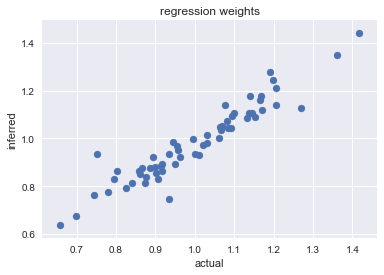

In [65]:
plt.scatter(Xlam.T.ravel(), inferred_means);
plt.xlabel('actual')
plt.ylabel('inferred')
plt.title('regression weights');